In [1]:
import requests
import pandas as pd
import numpy as np
import re
import sys, getopt
import csv
import pickle
import copy
import os
import math

pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

import umap
from sklearn.decomposition import TruncatedSVD as tsvd

def nearZeroVarDropAuto(df,thresh=0.99):
    vVal=df.var(axis=0).values
    cs=pd.Series(vVal).sort_values(ascending=False).cumsum()
    remove=cs[cs>cs.values[-1]*thresh].index.values
    return df.drop(df.columns[remove],axis=1)

%run SodaKick_download_functions.ipynb


import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD, Adagrad, Adam, Adagrad
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#from ray import tune
#from ray.tune import CLIReporter
#from ray.tune.schedulers import ASHAScheduler

from hyperopt import hp, tpe, fmin, Trials
from hyperopt import STATUS_OK, STATUS_FAIL
from hyperopt.pyll import scope

In [3]:
class EarlyStopping:

    """ Stops the training if loss doesn't improve after a given number of epochs. """

    def __init__(self, patience=3, epsilon=1e-5, keepBest=True, silent=True):

        """
        Args:
            patience (int): Number of epochs without change before stopping the learning (default 3).
            epsilon (float): Minimum change in loss to be considered for early stopping (default 1e-5).
            keepBest (bool): Keep track of the best model (memory consuming).
        """

        self.patience = patience
        self.epsilon = epsilon
        self.counter = 0
        
        self.bestScore = np.inf
     
        self.keepBest = keepBest 
        self.bestModel = None

        self.earlyStop = False
        self.silent = silent

    def __call__(self, loss, model):


        """ Evaluate the loss change between epochs and activates early stop if below epsilon.

        Args:
            loss (float): current loss.
            model (torch model): the current model.
        """

        if loss > self.bestScore - self.epsilon:

            self.counter += 1
            if not self.silent:
                print('EarlyStopping counter: {:d}/{:d}'.format(self.counter,self.patience))

            if self.counter >= self.patience:
                self.earlyStop = True

        else:   

            self.counter = 0
            self.bestScore = loss

            if self.keepBest:
                self.bestModel = copy.deepcopy(model)


In [4]:
class matchesDataset(Dataset):

    """ Extend pytorch Dataset class to include cleaning and training set creation, """
    
    def __init__(self, matches, results):

        self.matches = torch.tensor(matches, dtype=torch.float32)
        self.results = torch.tensor(results, dtype=torch.float32)

    def __len__(self):

        """ Returns the len of the training sample. """
        
        return len(self.matches)
        

    def __getitem__(self, index): 

        """ Returns a word, a context word and a list of negative words for training for a given index. 

        Args:
            index (int): index for the word selection.

        Returns:
            (string, string, list of strings): selected word, context word and a randomly drawn list 
                                               of negative words.

        """
        return self.matches[index], self.results[index]

In [5]:
#https://towardsdatascience.com/quirky-keras-custom-and-asymmetric-loss-functions-for-keras-in-r-a8b5271171fe
#weighted asimmetric square error, errors by going below the value (not seeing a goal when it's there) are weighted more

def WSE(output, target, a=1.5, b=.5):
    loss = torch.mean(a/(a+b)*torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      b/(a+b)*torch.maximum(torch.zeros(output.shape[1]),output - target)**2)      
    return loss

def WSEl1(output, target, a=1.5, b=.5):
    loss = torch.mean(a/(a+b)*torch.abs(torch.minimum(torch.zeros(output.shape[1]),output - target))+\
                      b/(a+b)*torch.abs(torch.maximum(torch.zeros(output.shape[1]),output - target)))      
    return loss

def WSE2(output, target, a=1.5, b=.5):
    loss = np.mean(a/(a+b)*np.minimum(np.zeros(output.shape[0]),output - target)**2+\
                      b/(a+b)*np.maximum(np.zeros(output.shape[0]),output - target)**2)      
    return loss

def WSEl12(output, target, a=1.25, b=.75):
    loss = np.mean(a/(a+b)*np.abs(np.minimum(np.zeros(output.shape[0]),output - target))+\
                      b/(a+b)*np.abs(np.maximum(np.zeros(output.shape[0]),output - target)))      
    return loss


def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))



def Wlog_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor, a=1.5, b=.5) -> torch.Tensor:

    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)   
        
    return torch.mean(a/(a+b)*_log_cosh(torch.minimum(torch.zeros(y_pred.shape[1]),y_pred - y_true))+\
                   b/(a+b)*_log_cosh(torch.maximum(torch.zeros(y_pred.shape[1]),y_pred - y_true)))


class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)
    
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1).data, arr.std(axis=-1).data

In [6]:
def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NormalizeMatrix(data):   
    for i in range(data.shape[1]):
        data[:,i] = NormalizeData(data[:,i])

def norm_max(out):
    
    maxes=[]
    for i in range(int(out.shape[1]/8.0)):
        maxes.append(out[:,8*int(i):8*(int(i)+1)].max(axis=0))

        #maxes.append(out.max(axis=1)[8*int(i):8*(int(i)+1):8])
    denominator=np.tile(np.max(maxes,axis=0),int(out.shape[1]/8))
    return out/denominator, denominator 

with open(r'/Users/federico comitani/GitHub/sodakick/data/wainp_220303.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/out_220303.pkl', 'rb') as pk:
    out=np.array(pickle.load(pk),dtype=float)
    
### skipping norm for now since it's already tsvd 
#NormalizeMatrix(inp)
#np.nan_to_num(inp, copy=False)

from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
inp = scaler.fit_transform(inp)

#normalize_mins(out)
out, denominator= norm_max(out)

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
         inp[:1000], out[:1000], test_size=0.2, random_state=32)

In [8]:
class Net(nn.Module):
    
    #=nn.LeakyReLU()
    
    def __init__(self, num_layers, num_nodes_in, num_nodes, num_nodes_out, final_activation, batch_norm, dropout, activation):
        super(Net, self).__init__()
        
        self.fc = []
        self.lr = []
        self.bn = []
        self.dp = []
        self.act = activation
        self.fact = final_activation
        self.nl = num_layers
        self.batch_norm = batch_norm
        self.dropout = dropout
        
        power=0
        
        for i in range(self.nl):
            if i==0:
                self.fc.append(nn.Linear(int(num_nodes_in), int(num_nodes)))
            else:
                self.fc.append(nn.Linear(int(num_nodes), int(num_nodes)))
            self.lr.append(self.act)
            
            if self.batch_norm:
                self.bn.append(nn.BatchNorm1d(int(num_nodes)))

            if self.dropout>0.0:
                self.dp.append(nn.Dropout(dropout))
                
            power+=1
        
        self.oupt = nn.Linear(int(num_nodes), int(num_nodes_out))
    
    def reset_weights(self):

        """ Resets network weights according to chosen distribution. """

        for f in self.fc:
            nn.init.xavier_uniform_(f.weight, gain=np.sqrt(2/(1+0.01**2)))

            
    def forward(self, x):
        z = x
        for i in range(self.nl):
            
            z = self.fc[i](z)
            
            if self.batch_norm:
                z = self.bn[i](z)
            
            z = self.lr[i](z)
        
            if self.dropout>0.0:
                z = self.dp[i](z)
                
        if self.fact is not None:
            z = self.fact(z)
        
        z = self.oupt(z)
        
        return z
    
    def clp(self):
        with torch.no_grad():
            for i in range(self.nl):
                self.fc[i].weight.copy_ (self.fc[i].weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))

In [9]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))

print(np.abs(out[1]-out[10]).sum())
print(np.abs(out[50]-out[60]).sum())
print(np.abs(out[100]-out[110]).sum())

Baseline WSE: 0.039
Baseline WSE l1: 0.043
Baseline MSE: 0.026
Baseline MSE l1: 0.035
36.36507936507937
24.09365079365079
34.76825396825397


In [10]:
def revert_output(output,multiplier=denominator,lineup=None):

    reframe=pd.DataFrame(output.reshape(48,8),
                 columns=['minutes','goals','assists','cards_yellow','cards_red','own_goals','goals_against','saves'])
    
    reframe[reframe<0] = 0
    if lineup is not None:
        reframe.index=lineup
        reframe.drop([x for x in reframe.index if x.startswith('dummy')], axis=0, inplace=True)
    
    
    #reframe['minutes']*=90
    reframe=reframe*denominator[:8]
    byteamframe=pd.concat([reframe.iloc[:24,:].sum(axis=0),reframe.iloc[24:,:].sum(axis=0)], axis=1).T
    
    return reframe, byteamframe[byteamframe.columns[1:]]

# ensemble, kfold

In [11]:
from tqdm import tqdm

def train_alone(config, data, model=Net, silent=True, checkpoint_dir=None):
    
    phases = ['train','val']
    
    x_train, y_train, x_test, y_test = data[0], data[1], data[2], data[3]

    training_set = matchesDataset(x_train, y_train)
    trainBatch = torch.utils.data.DataLoader(training_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'])

    validation_set = matchesDataset(x_test, y_test)
    valBatch = torch.utils.data.DataLoader(validation_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'])

    earlStop = EarlyStopping(patience=int(config['patience']), epsilon=config['epsilon'], keepBest=False)

    net = model(config['num_layers'], config['num_nodes_in'],  config['num_nodes'],
                    config['num_nodes_out'], config['final_activation'], config['batch_norm'], config['dropout'], config['activation'])

    net.reset_weights()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    if config['optim']=='adam':
        optimizer = Adam(net.parameters(), lr=config['lr'])
    elif config['optim']=='adagrad':
        optimizer = Adagrad(net.parameters(), lr=config['lr'])
    else:
        print('optim error')
        return


    losses=[[],[]]
    mses=[]
    diffs=[]
    exit=False

    for epoch in tqdm(range(config['epochs']), desc='Epoch'):
    #for epoch in range(config['epochs']):

        if exit:
            break

        for phase in phases:
            if phase == 'train':
                net.train(True) 

                """ Run the training of the model. """    

                losses_batch=[]
                mses_batch=[]
                for batchNum, batch in enumerate(trainBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """

                    loss = config['loss_f'](net(x), y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    if config['clip']:
                        net.clp()

                    losses_batch.append(loss)
                    #mses_batch.append(nn.MSELoss()(net(x), y).detach().numpy())


                """ Early stop check. """

                earlStop(loss, net)
                finalepoch = epoch

                if earlStop.earlyStop:

                    if not silent:
                        print('Limit loss improvement reached, stopping the training.')

                    exit=True 

                losses[0].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
                #mse[0].append(torch.mean(torch.stack(mses_batch)).detach().cpu().numpy())

            else:
                net.train(False)
                net.eval()

                val_loss=0
                val_mse=0

                losses_batch=[]
                mses_batch=[]
                diff_batch=[]

                for batchNum, batch in enumerate(valBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """

                    optimizer.zero_grad()
                    output=net(x)
                    target=y
                    loss = config['loss_f'](output, target)

                    losses_batch.append(loss)
                    #mses_batch.append(nn.MSELoss()(output, target).detach().numpy())
                    
                    val_loss+=loss.detach().numpy()
                    #val_mse+=nn.MSELoss()(output, target).detach().numpy()
                    diff_batch.append(output-target)
                    
                losses[1].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
                #mse[1].append(torch.mean(torch.stack(mses_batch)).detach().cpu().numpy())
                diffs.append(torch.mean(torch.cat(diff_batch, dim=0), dim=0).detach().cpu().numpy())
                
    return net, val_loss/batchNum, losses, diffs #mses

In [12]:
from sklearn.model_selection import KFold

def runKfold(data, model, config, n_models=5, n_splits=5):
    
    kf = KFold(n_splits=n_splits, shuffle=True)
    kf.get_n_splits(data[0])

    trlosses=[]
    losses=[]
    ec=[]
    mss=[]
    diffs=[]
    oobs=[]
    
    for train_index, test_index in kf.split(data[0]):
        x_train, y_train, x_test, y_test = pd.DataFrame(data[0][train_index]), pd.DataFrame(data[1][train_index]), data[0][test_index], data[1][test_index]
                
        nets=[]
        oobs.append([])
        pred_train=[]
        pred_test=[]
        for m in range(n_models):
            
            #print(m, end=' ')
        
            x_train_bag = x_train.sample(frac=.9, replace=True, random_state=m)
            y_train_bag = y_train.loc[x_train_bag.index].values
            
            x_test_bag  = x_train.loc[[x for x in x_train.index if x not in x_train_bag.index]].values
            y_test_bag  = y_train.loc[[x for x in x_train.index if x not in x_train_bag.index]].values
            
            x_train_bag = x_train_bag.values

            net, val_loss, ls, df = train_alone(config, [x_train_bag, y_train_bag, x_test_bag, y_test_bag], model, silent=True, checkpoint_dir=None)
            
            nets.append(net)
            oobs[-1].append(val_loss)
            
            pred_train.append(net(torch.Tensor(x_train.values)))#.detach().cpu().numpy())
            pred_test.append(net(torch.Tensor(x_test)))#.detach().cpu().numpy())
            
        pred_train = torch.mean(torch.stack(pred_train),axis=0)
        pred_test = torch.mean(torch.stack(pred_test),axis=0)
        
        """print(pred_train[-1].shape)
        print(pred_train.shape,y_train.values.shape)
        print(config['loss_f'](pred_train, torch.Tensor(y_train.values)).detach().cpu().numpy())
        print(np.mean(config['loss_f'](pred_train, torch.Tensor(y_train.values)).detach().cpu().numpy()))
        
        print(pred_test[-1].shape)
        print(pred_test.shape,y_test.shape)
        print(config['loss_f'](pred_test, torch.Tensor(y_test)).detach().cpu().numpy())
        print(np.mean(config['loss_f'](pred_test, torch.Tensor(y_test)).detach().cpu().numpy()))
        
        print()
        print(torch.mean(pred_test-torch.Tensor(y_test),axis=0).detach().cpu().numpy().reshape(-1, 48).shape)
        """
        
        trlosses.append(np.mean(config['loss_f'](pred_train, torch.Tensor(y_train.values)).detach().cpu().numpy()))
        losses.append(np.mean(config['loss_f'](pred_test, torch.Tensor(y_test)).detach().cpu().numpy()))
        diffs.append(torch.mean(pred_test-torch.Tensor(y_test),axis=0).detach().cpu().numpy().reshape(-1, 48))
                
    errs=[np.mean(x, axis=1) for x in diffs]
    meaerrs=np.mean(errs, axis=0)
    meastd=np.std(errs, axis=0)

    abserrs=[np.mean(np.abs(x), axis=1) for x in diffs]
    absmeaerrs=np.mean(abserrs, axis=0)
    absmeastd=np.std(abserrs, axis=0)
        
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    return nets, [trlosses,losses], [meaerrs, meastd], [absmeaerrs, absmeastd]

Epoch: 100%|██████████| 100/100 [27:34<00:00, 16.55s/it]


KFold Result: 0.004+/-0.000
34.76059
18.934996
18.458145
KFold Result Train: 0.004+/-0.000
KFold Result Test: 0.004+/-0.000


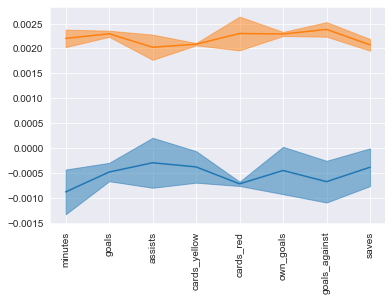

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        0             1          0          0              1      3
1      1        1             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      3
1      1        0             2          0          0              2      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      3
1      1        0             2          0          0              2      3


In [14]:
 config = {
        "num_layers": 2,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/5,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "epsilon":1e-6, 
        "patience": 500,
        "epochs": 100
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=3, n_splits=3)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))


reframe, byteamframe = revert_output(pred[i+1000])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(pred[i+1000])
print(byteamframe.astype(int))


print('rmse from avg: {:.4f}'.format(((pred-out.mean(axis=0))**2).sum(axis=1).mean()))

rmse from avg: 7.4601


Epoch: 100%|██████████| 100/100 [47:34<00:00, 28.55s/it]


KFold Result: 0.003+/-0.000
36.681656
20.574345
19.595112
KFold Result Train: 0.003+/-0.000
KFold Result Test: 0.003+/-0.000


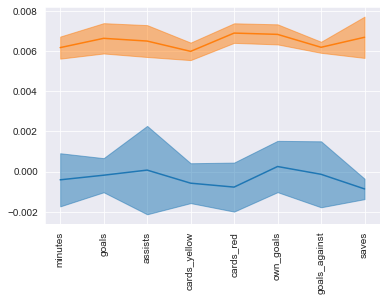

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             2          0          0              1      3
1      1        1             2          0          0              2      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        0             2          0          0              1      3
1      1        1             2          0          0              2      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        0             2          0          0              1      3
1      1        1             2          0          0              2      3
rmse from avg: 8.6596


In [39]:
 config = {
        "num_layers": 2,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "epsilon":1e-6, 
        "patience": 500,
        "epochs": 100
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=1, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))


reframe, byteamframe = revert_output(pred[i+1000])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(pred[i+1000])
print(byteamframe.astype(int))


print('rmse from avg: {:.4f}'.format(((pred-out.mean(axis=0))**2).sum(axis=1).mean()))


Epoch: 100%|██████████| 100/100 [58:31<00:00, 35.12s/it] 


KFold Result: 0.007+/-0.000
37.983227
20.927906
20.947596
KFold Result Train: 0.007+/-0.000
KFold Result Test: 0.007+/-0.000


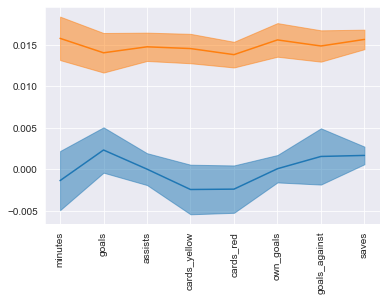

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              2      4
1      1        1             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      2        1             2          0          0              1      4
1      1        1             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      2        1             2          0          0              1      4
1      1        1             2          0          0              2      4
rmse from avg: 8.7481


In [41]:
 config = {
        "num_layers": 3,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": nn.MSELoss(),#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0005,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "epsilon":1e-6, 
        "patience": 500,
        "epochs": 100
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=1, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))


reframe, byteamframe = revert_output(pred[i+1000])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(pred[i+1000])
print(byteamframe.astype(int))


print('rmse from avg: {:.4f}'.format(((pred-out.mean(axis=0))**2).sum(axis=1).mean()))


In [17]:
from sklearn.model_selection import KFold

def runKfold_onthefly(data, model, config, n_models=5, n_splits=5):
    
    num_layers=np.random.choice(config["num_layers"],n_models*n_splits)
    num_nodes=np.random.choice(config["num_nodes"],n_models*n_splits)
    
    kf = KFold(n_splits=n_splits, shuffle=True)
    kf.get_n_splits(data[0])

    trlosses=[]
    losses=[]
    ec=[]
    mss=[]
    diffs=[]
    oobs=[]
    
    n=0
    for train_index, test_index in kf.split(data[0]):
        x_train, y_train, x_test, y_test = pd.DataFrame(data[0][train_index]), pd.DataFrame(data[1][train_index]), data[0][test_index], data[1][test_index]
                
        nets=[]
        oobs.append([])
        pred_train=[]
        pred_test=[]
        for m in range(n_models):
            
            config['num_layers']=num_layers[(n*5)+m]
            config['num_nodes']=num_nodes[(n*5)+m]
            print(m, config['num_layers'], config['num_nodes'])
        
            x_train_bag = x_train.sample(frac=.9, replace=True, random_state=m)
            y_train_bag = y_train.loc[x_train_bag.index].values
            
            x_test_bag  = x_train.loc[[x for x in x_train.index if x not in x_train_bag.index]].values
            y_test_bag  = y_train.loc[[x for x in x_train.index if x not in x_train_bag.index]].values
            
            x_train_bag = x_train_bag.values

            net, val_loss, ls, df = train_alone(config, [x_train_bag, y_train_bag, x_test_bag, y_test_bag], model, silent=True, checkpoint_dir=None)
            
            nets.append(net)
            oobs[-1].append(val_loss)
            
            pred_train.append(net(torch.Tensor(x_train.values)))#.detach().cpu().numpy())
            pred_test.append(net(torch.Tensor(x_test)))#.detach().cpu().numpy())
            
        pred_train = torch.mean(torch.stack(pred_train),axis=0)
        pred_test = torch.mean(torch.stack(pred_test),axis=0)
        
        trlosses.append(np.mean(config['loss_f'](pred_train, torch.Tensor(y_train.values)).detach().cpu().numpy()))
        losses.append(np.mean(config['loss_f'](pred_test, torch.Tensor(y_test)).detach().cpu().numpy()))
        diffs.append(torch.mean(pred_test-torch.Tensor(y_test),axis=0).detach().cpu().numpy().reshape(-1, 48))
                
        n+=1
        
    errs=[np.mean(x, axis=1) for x in diffs]
    meaerrs=np.mean(errs, axis=0)
    meastd=np.std(errs, axis=0)

    abserrs=[np.mean(np.abs(x), axis=1) for x in diffs]
    absmeaerrs=np.mean(abserrs, axis=0)
    absmeastd=np.std(abserrs, axis=0)
        
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    return nets, [trlosses,losses], [meaerrs, meastd], [absmeaerrs, absmeastd]

0 3 272


Epoch:  18%|█▊        | 9/50 [02:52<13:04, 19.12s/it]


1 1 163


Epoch:  36%|███▌      | 18/50 [03:44<06:38, 12.47s/it]


2 4 163


Epoch:  20%|██        | 10/50 [02:38<10:32, 15.81s/it]


3 3 408


Epoch:  14%|█▍        | 7/50 [02:59<18:21, 25.63s/it]


4 1 204


Epoch:  20%|██        | 10/50 [02:05<08:22, 12.56s/it]


0 2 272


Epoch:  32%|███▏      | 16/50 [04:17<09:06, 16.08s/it]


1 1 408


Epoch:  26%|██▌       | 13/50 [04:13<12:00, 19.47s/it]


2 1 204


Epoch:  32%|███▏      | 16/50 [03:39<07:46, 13.71s/it]


3 1 163


Epoch:  26%|██▌       | 13/50 [02:46<07:55, 12.84s/it]


4 4 163


Epoch:  40%|████      | 20/50 [05:11<07:46, 15.55s/it]


0 4 272


Epoch:  34%|███▍      | 17/50 [04:38<09:01, 16.40s/it]


1 1 272


Epoch:  16%|█▌        | 8/50 [01:29<07:48, 11.16s/it]


2 4 163


Epoch:  24%|██▍       | 12/50 [02:05<06:37, 10.46s/it]


3 4 163


Epoch:  30%|███       | 15/50 [02:48<06:32, 11.20s/it]


4 3 408


Epoch:  18%|█▊        | 9/50 [02:31<11:32, 16.88s/it]


0 1 272


Epoch:  18%|█▊        | 9/50 [01:24<06:23,  9.36s/it]


1 3 204


Epoch:  20%|██        | 10/50 [01:49<07:19, 10.99s/it]


2 1 408


Epoch:  20%|██        | 10/50 [01:56<07:45, 11.63s/it]


3 3 204


Epoch:  24%|██▍       | 12/50 [02:05<06:35, 10.42s/it]


4 3 163


Epoch:  26%|██▌       | 13/50 [02:01<05:47,  9.38s/it]


0 3 408


Epoch:  16%|█▌        | 8/50 [02:14<11:47, 16.85s/it]


1 4 408


Epoch:  34%|███▍      | 17/50 [05:27<10:35, 19.25s/it]


2 3 163


Epoch:  16%|█▌        | 8/50 [01:18<06:50,  9.76s/it]


3 2 163


Epoch:  28%|██▊       | 14/50 [02:19<05:58,  9.96s/it]


4 2 204


Epoch:  42%|████▏     | 21/50 [03:40<05:04, 10.50s/it]


KFold Result: 0.003+/-0.000
31.397055
20.77724
18.84803
KFold Result Train: 0.003+/-0.000
KFold Result Test: 0.003+/-0.000


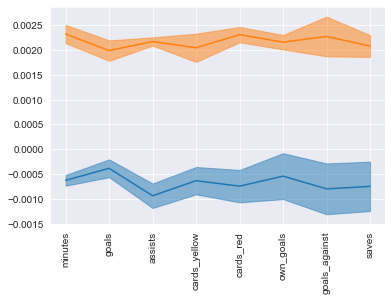

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      2
1      1        0             2          0          0              1      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [235]:
 config = {
        "num_layers": [1,2,3,4],
        "num_nodes_in": inp.shape[1],
        "num_nodes": [int(inp.shape[1]/5),int(inp.shape[1]/4),int(inp.shape[1]/3),int(inp.shape[1]/2)],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 50
    }
    
nets, losses, errs, abserrs=runKfold_onthefly([inp, out], Net, config, n_models=5, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  20%|██        | 10/50 [01:31<06:06,  9.16s/it]


KFold Result: 0.003+/-0.000
33.536674
18.265581
17.603857
KFold Result Train: 0.003+/-0.000
KFold Result Test: 0.003+/-0.000


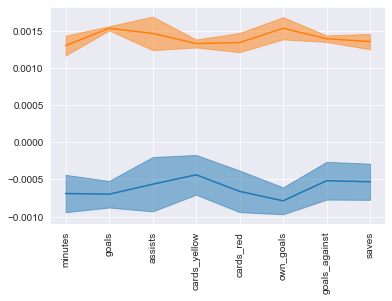

NameError: name 'revert_output' is not defined

In [13]:
 config = {
        "num_layers": 2,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/5,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 50
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=10, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

In [15]:
reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        0             1          0          0              1      2
1      1        0             1          0          0              1      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


0 3 408


Epoch:  28%|██▊       | 14/50 [03:35<09:14, 15.39s/it]


1 3 408


Epoch:  38%|███▊      | 19/50 [04:52<07:56, 15.39s/it]


2 1 204


Epoch:  38%|███▊      | 19/50 [02:35<04:14,  8.20s/it]


3 3 272


Epoch:  26%|██▌       | 13/50 [02:36<07:26, 12.07s/it]


4 2 272


Epoch:  30%|███       | 15/50 [02:39<06:13, 10.66s/it]


5 1 204


Epoch:  36%|███▌      | 18/50 [02:29<04:25,  8.29s/it]


6 1 204


Epoch:  28%|██▊       | 14/50 [01:53<04:52,  8.13s/it]


7 2 204


Epoch:  30%|███       | 15/50 [02:16<05:19,  9.13s/it]


8 2 272


Epoch:  38%|███▊      | 19/50 [03:18<05:24, 10.46s/it]


9 1 408


Epoch:  28%|██▊       | 14/50 [02:34<06:38, 11.07s/it]


0 1 204


Epoch:  34%|███▍      | 17/50 [02:17<04:26,  8.07s/it]


1 1 204


Epoch:  24%|██▍       | 12/50 [01:48<05:45,  9.08s/it]


2 2 204


Epoch:  32%|███▏      | 16/50 [02:30<05:19,  9.40s/it]


3 2 272


Epoch:  28%|██▊       | 14/50 [02:39<06:50, 11.40s/it]


4 1 408


Epoch:  18%|█▊        | 9/50 [01:37<07:24, 10.84s/it]


5 3 272


Epoch:  30%|███       | 15/50 [03:05<07:12, 12.36s/it]


6 3 204


Epoch:  22%|██▏       | 11/50 [02:01<07:12, 11.08s/it]


7 2 204


Epoch:  32%|███▏      | 16/50 [02:42<05:45, 10.15s/it]


8 1 204


Epoch:  28%|██▊       | 14/50 [02:07<05:28,  9.13s/it]


9 2 204


Epoch:  34%|███▍      | 17/50 [02:55<05:39, 10.30s/it]


0 3 272


Epoch:  28%|██▊       | 14/50 [02:52<07:24, 12.35s/it]


1 3 204


Epoch:  32%|███▏      | 16/50 [02:48<05:58, 10.56s/it]


2 2 204


Epoch:  30%|███       | 15/50 [02:27<05:43,  9.81s/it]


3 1 204


Epoch:  24%|██▍       | 12/50 [01:38<05:10,  8.18s/it]


4 2 204


Epoch:  28%|██▊       | 14/50 [02:10<05:34,  9.31s/it]


5 1 408


Epoch:  18%|█▊        | 9/50 [01:39<07:32, 11.04s/it]


6 1 408


Epoch:  20%|██        | 10/50 [01:53<07:34, 11.37s/it]


7 3 204


Epoch:  28%|██▊       | 14/50 [02:49<07:14, 12.07s/it]


8 3 204


Epoch:  16%|█▌        | 8/50 [01:23<07:20, 10.49s/it]


9 1 408


Epoch:  14%|█▍        | 7/50 [01:24<08:41, 12.12s/it]


0 1 408


Epoch:  20%|██        | 10/50 [02:03<08:14, 12.37s/it]


1 1 408


Epoch:  26%|██▌       | 13/50 [02:36<07:25, 12.03s/it]


2 3 204


Epoch:  22%|██▏       | 11/50 [02:04<07:19, 11.28s/it]


3 3 204


Epoch:  24%|██▍       | 12/50 [02:18<07:17, 11.52s/it]


4 1 408


Epoch:  14%|█▍        | 7/50 [01:20<08:14, 11.49s/it]


5 1 272


Epoch:  24%|██▍       | 12/50 [01:57<06:12,  9.79s/it]


6 3 408


Epoch:  24%|██▍       | 12/50 [03:15<10:17, 16.25s/it]


7 1 272


Epoch:  32%|███▏      | 16/50 [02:39<05:38,  9.96s/it]


8 2 204


Epoch:  22%|██▏       | 11/50 [01:45<06:14,  9.61s/it]


9 1 408


Epoch:  16%|█▌        | 8/50 [01:40<08:49, 12.61s/it]


0 1 272


Epoch:  28%|██▊       | 14/50 [02:14<05:47,  9.64s/it]


1 3 408


Epoch:  22%|██▏       | 11/50 [02:49<10:01, 15.43s/it]


2 1 272


Epoch:  24%|██▍       | 12/50 [01:57<06:12,  9.81s/it]


3 2 204


Epoch:  48%|████▊     | 24/50 [03:36<03:54,  9.03s/it]


4 1 408


Epoch:  24%|██▍       | 12/50 [02:16<07:12, 11.38s/it]


5 3 408


Epoch:  36%|███▌      | 18/50 [04:52<08:39, 16.23s/it]


6 3 204


Epoch:  18%|█▊        | 9/50 [01:46<08:07, 11.88s/it]


7 1 272


Epoch:  26%|██▌       | 13/50 [02:13<06:21, 10.30s/it]


8 2 272


Epoch:  20%|██        | 10/50 [01:45<07:03, 10.58s/it]


9 3 272


Epoch:  22%|██▏       | 11/50 [02:11<07:44, 11.91s/it]


KFold Result: 0.003+/-0.000
33.94715
18.229177
17.674072
KFold Result Train: 0.003+/-0.000
KFold Result Test: 0.003+/-0.000


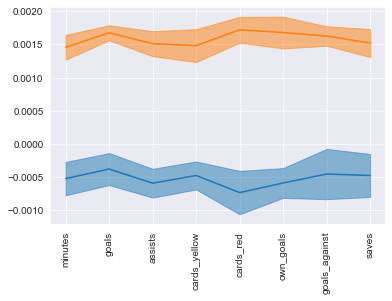

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      3
1      1        0             2          0          0              1      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [18]:
 config = {
        "num_layers": [1,2,3],
        "num_nodes_in": inp.shape[1],
        "num_nodes": [int(inp.shape[1]/4),int(inp.shape[1]/3),int(inp.shape[1]/2)],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 50
    }
    
nets, losses, errs, abserrs=runKfold_onthefly([inp, out], Net, config, n_models=10, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  44%|████▍     | 22/50 [03:33<04:32,  9.72s/it]


KFold Result: 0.003+/-0.000
31.11296
16.06913
16.741495
KFold Result Train: 0.003+/-0.000
KFold Result Test: 0.003+/-0.000


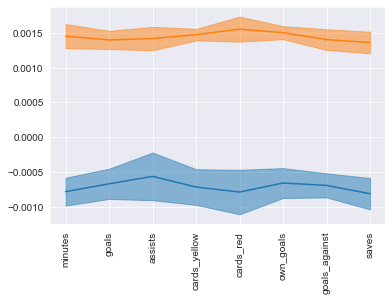

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      2
1      1        0             2          0          0              1      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [19]:
 config = {
        "num_layers": 3,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/5,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 50
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=10, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch: 100%|██████████| 25/25 [15:37<00:00, 37.50s/it]


KFold Result: 0.003+/-0.000
34.56161
21.85432
21.836063
KFold Result Train: 0.003+/-0.000
KFold Result Test: 0.003+/-0.000


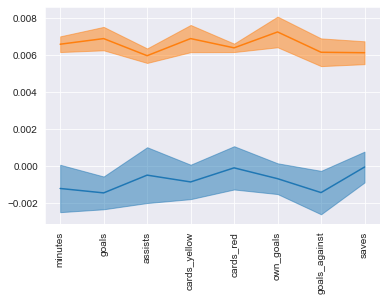

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             2          0          0              1      3
1      1        0             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [41]:
 config = {
        "num_layers": 3,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 50,
        "epsilon":1e-6, 
        "epochs": 25
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=1, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

In [43]:
for i in [0,10000,500,100000]:
    cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

    reframe, byteamframe = revert_output(pred[i])
    print(byteamframe)
    reframe, byteamframe = revert_output(out[i])
    print(byteamframe.astype(int))
    print()

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  2.231939  1.826244      2.090416   0.149428   0.094699       1.581552   
1  1.140687  0.652879      2.082909   0.197357   0.062220       2.656081   

      saves  
0  2.795248  
1  4.474113  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      4        4             1          0          0              0      4
1      0        0             2          0          0              4      4

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  2.082279  1.787717      1.721687   0.165081   0.084857       1.338306   
1  0.857602  0.649439      1.808736   0.176213   0.064212       2.889474   

      saves  
0  3.128425  
1  4.361162  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      3        2             2          0          0              0      1
1      0        0             0          0          0              3      2



Epoch: 100%|██████████| 25/25 [06:33<00:00, 15.74s/it]


KFold Result: 0.003+/-0.000
35.50329
19.649746
18.72363
KFold Result Train: 0.003+/-0.000
KFold Result Test: 0.003+/-0.000


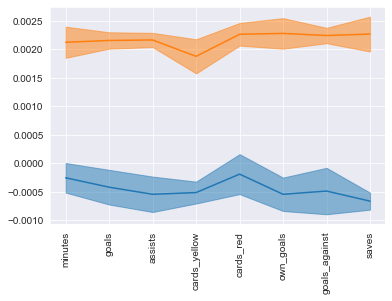

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             2          0          0              1      2
1      1        0             2          0          0              1      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [49]:
 config = {
        "num_layers": 1,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 50,
        "epsilon":1e-6, 
        "epochs": 25
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=10, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

In [50]:
for i in [0,10000,500,100000]:
    cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

    reframe, byteamframe = revert_output(pred[i])
    print(byteamframe)
    reframe, byteamframe = revert_output(out[i])
    print(byteamframe.astype(int))
    print()

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  2.175386  1.569782      1.957105   0.073357   0.043927       1.276598   
1  1.027351  0.602364      2.204746   0.096785   0.063859       2.414673   

      saves  
0  2.425753  
1  3.961755  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      4        4             1          0          0              0      4
1      0        0             2          0          0              4      4

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.945690  1.401756      1.668227   0.044750   0.029066       1.377635   
1  1.132221  0.833960      1.966284   0.068566   0.044426       2.162368   

      saves  
0  2.682376  
1  3.619148  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      3        2             2          0          0              0      1
1      0        0             0          0          0              3      2



In [51]:
 config = {
        "num_layers": 1,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": Wlog_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 50,
        "epsilon":1e-6, 
        "epochs": 25
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=10, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  72%|███████▏  | 18/25 [11:47<04:35, 39.32s/it]


KeyboardInterrupt: 

In [ ]:
for i in [0,10000,500,100000]:
    cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

    reframe, byteamframe = revert_output(pred[i])
    print(byteamframe)
    reframe, byteamframe = revert_output(out[i])
    print(byteamframe.astype(int))
    print()

Epoch: 100%|██████████| 25/25 [09:29<00:00, 22.77s/it]


KFold Result: 0.004+/-0.000
39.00741
23.217642
21.008663
KFold Result Train: 0.004+/-0.000
KFold Result Test: 0.004+/-0.000


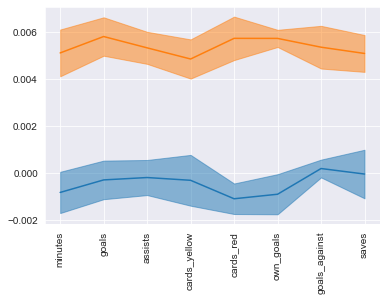

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      3
1      1        1             2          0          0              2      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [44]:
 config = {
        "num_layers": 4,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/2,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 50,
        "epsilon":1e-6, 
        "epochs": 25
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=1, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

In [45]:
for i in [0,10000,500,100000]:
    cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

    reframe, byteamframe = revert_output(pred[i])
    print(byteamframe)
    reframe, byteamframe = revert_output(out[i])
    print(byteamframe.astype(int))
    print()

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  2.040215  1.604066      2.035260   0.116796   0.069316       1.666596   
1  1.264131  0.972396      2.053585   0.114959   0.100392       2.400839   

      saves  
0  3.215224  
1  3.899981  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      4        4             1          0          0              0      4
1      0        0             2          0          0              4      4

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.985991  1.512235      1.772529   0.073637   0.056308       1.978611   
1  1.411154  1.037478      1.898890   0.050671   0.058929       2.756490   

      saves  
0  3.373348  
1  4.879425  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      3        2             2          0          0              0      1
1      0        0             0          0          0              3      2



Epoch: 100%|██████████| 25/25 [12:17<00:00, 29.49s/it]


KFold Result: 0.004+/-0.000
36.880894
23.17464
19.142452
KFold Result Train: 0.004+/-0.000
KFold Result Test: 0.004+/-0.000


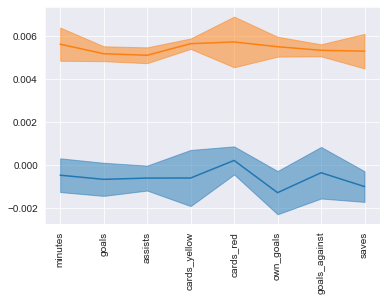

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      3
1      1        0             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [46]:
 config = {
        "num_layers": 6,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/2,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 50,
        "epsilon":1e-6, 
        "epochs": 25
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=1, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

In [47]:
for i in [0,10000,500,100000]:
    cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

    reframe, byteamframe = revert_output(pred[i])
    print(byteamframe)
    reframe, byteamframe = revert_output(out[i])
    print(byteamframe.astype(int))
    print()

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.486620  0.870732      2.363866   0.138098   0.088374       2.137479   
1  1.411229  1.242251      2.090373   0.162585   0.088660       2.153908   

      saves  
0  4.001372  
1  3.896155  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      4        4             1          0          0              0      4
1      0        0             2          0          0              4      4

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.703468  1.174769      1.898975   0.158976   0.066580       1.712947   
1  1.016693  0.791798      1.986550   0.190987   0.093661       2.439783   

      saves  
0  3.820258  
1  4.501498  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      3        2             2          0          0              0      1
1      0        0             0          0          0              3      2



Epoch:  14%|█▍        | 7/50 [01:31<09:20, 13.04s/it]


KFold Result: 0.003+/-0.000
33.585495
17.928848
18.183666
KFold Result Train: 0.003+/-0.000
KFold Result Test: 0.003+/-0.000


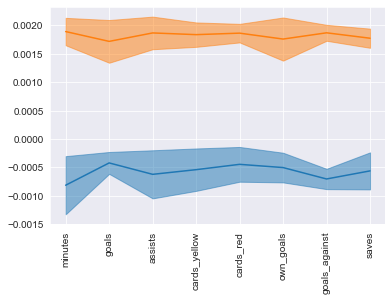

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      2
1      1        0             1          0          0              1      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [13]:
 config = {
        "num_layers": 2,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/2,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 50
    }
    
nets, losses, errs, abserrs=runKfold([inp, out], Net, config, n_models=10, n_splits=5)
    
print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[1] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[10] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[50] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[60] for net in nets], axis=0))).sum())

print((np.abs(np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[100] for net in nets], axis=0)\
       -np.mean([net(torch.Tensor(inp)).detach().cpu().numpy()[110] for net in nets], axis=0))).sum())

print('KFold Result Train: {:.3f}+/-{:.3f}'.format(np.mean(losses[0]),np.std(losses[0])))
print('KFold Result Test: {:.3f}+/-{:.3f}'.format(np.mean(losses[1]),np.std(losses[1])))

#plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
#plt.plot(lsmea[0], color='#1f77b4')
#plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
#plt.plot(lsmea[1], color='#ff7f0e')
#plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=np.mean([net(torch.Tensor(inp)).detach().cpu().numpy() for net in nets], axis=0)

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

In [ ]:
#try stacking